# Economic Data Analysis with FRED & Pandas
Pull The data, Visualize, discover insights... All with python/pandas!



In [ ]:
pip install fredapi

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import time

plt.style.use('fivethirtyeight')
#pd.set_option('max_columns', 500)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

from fredapi import Fred

In [9]:
# Using API key from FRED to request data
fred_key = 'my_api_key' #my API key (not shown publicly)

# 1. Create The Fred Object

In [10]:
fred = Fred(api_key=fred_key)

# 2. Search for economic data

In [32]:
# search S&P data
sp_search = fred.search('S&P', order_by='popularity')

In [33]:
sp_search.head()

id realtime_start realtime_end  \
series id                                                    
BAMLH0A0HYM2      BAMLH0A0HYM2     2024-04-01   2024-04-01   
CSUSHPINSA          CSUSHPINSA     2024-04-01   2024-04-01   
SP500                    SP500     2024-04-01   2024-04-01   
MEHOINUSA672N    MEHOINUSA672N     2024-04-01   2024-04-01   
BAMLH0A0HYM2EY  BAMLH0A0HYM2EY     2024-04-01   2024-04-01   

                                                            title  \
series id                                                           
BAMLH0A0HYM2    ICE BofA US High Yield Index Option-Adjusted S...   
CSUSHPINSA      S&P CoreLogic Case-Shiller U.S. National Home ...   
SP500                                                     S&P 500   
MEHOINUSA672N   Real Median Household Income in the United States   
BAMLH0A0HYM2EY       ICE BofA US High Yield Index Effective Yield   

               observation_start observation_end     frequency  \
series id                                                        
BAMLH0A0HYM2          1996-12-31      2024-03-31  Daily, Close   
CSUSHPINSA            1987-01-01      2024-01-01       Monthly   
SP500                 2014-03-31      2024-03-28  Daily, Close   
MEHOINUSA672N         1984-01-01      2022-01-01        Annual   
BAMLH0A0HYM2EY        1996-12-31      2024-03-31  Daily, Close   

               frequency_short                           units  \
series id                                                        
BAMLH0A0HYM2                 D                         Percent   
CSUSHPINSA                   M              Index Jan 2000=100   
SP500                        D                           Index   
MEHOINUSA672N                A  2022 CPI-U-RS Adjusted Dollars   
BAMLH0A0HYM2EY               D                         Percent   

                             units_short      seasonal_adjustment  \
series id                                                           
BAMLH0A0HYM2                           %  Not Seasonally Adjusted   
CSUSHPINSA            Index Jan 2000=100  Not Seasonally Adjusted   
SP500                              Index  Not Seasonally Adjusted   
MEHOINUSA672N   2022 CPI-U-RS Adjusted $  Not Seasonally Adjusted   
BAMLH0A0HYM2EY                         %  Not Seasonally Adjusted   

               seasonal_adjustment_short               last_updated  \
series id                                                             
BAMLH0A0HYM2                         NSA  2024-04-01 09:26:14-05:00   
CSUSHPINSA                           NSA  2024-03-26 08:11:02-05:00   
SP500                                NSA  2024-03-28 19:10:49-05:00   
MEHOINUSA672N                        NSA  2023-09-12 13:48:02-05:00   
BAMLH0A0HYM2EY                       NSA  2024-04-01 09:26:18-05:00   

               popularity                                              notes  
series id                                                                     
BAMLH0A0HYM2           92  The ICE BofA Option-Adjusted Spreads (OASs) ar...  
CSUSHPINSA             88  For more information regarding the index, plea...  
SP500                  83  The observations for the S&P 500 represent the...  
MEHOINUSA672N          83  Household data are collected as of March.  As ...  
BAMLH0A0HYM2EY         82  This data represents the effective yield of th...

# 3. Pull Raw Data & Plot

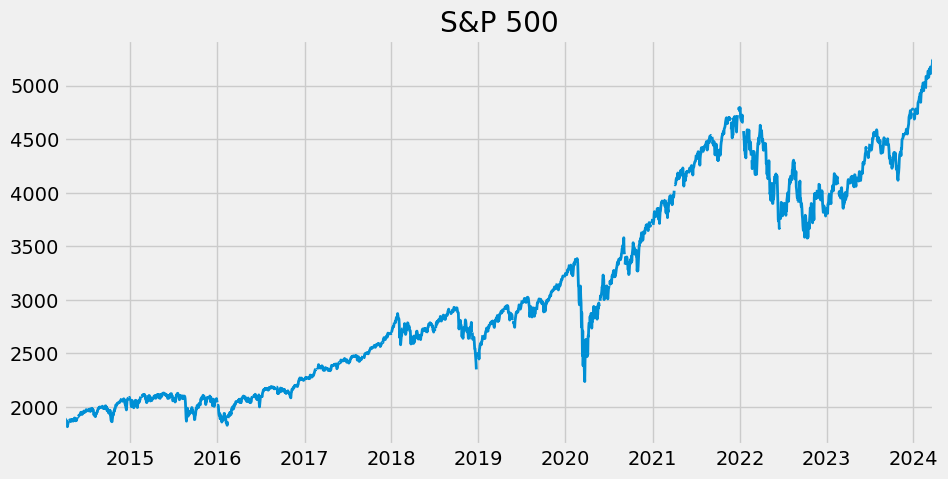

In [31]:
# get S&P 500 data and plot a line chart
sp500 = fred.get_series(series_id='SP500')

sp500.plot(figsize=(10, 5), title='S&P 500', lw=2)
plt.show()

# 4. Pull and Join Multiple Data Series¶

In [15]:
# pull monthly, seasonally adjusted unemployment rate for all states in percent
unemp_df = fred.search('unemployment rate state', filter=('frequency','Monthly'))
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate')]

In [22]:
# get unemployment rates for all ids and concatonate them in one dataframe
all_results = []

for myid in unemp_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    time.sleep(2.2) # Don't request to fast and get blocked
uemp_results = pd.concat(all_results, axis=1)

In [25]:
# drop non relevant columns
cols_to_drop = []
for i in uemp_results:
    if len(i) > 4:
        cols_to_drop.append(i)
uemp_results = uemp_results.drop(columns = cols_to_drop, axis=1)

In [30]:
#check for NANs
uemp_results.isna().sum(axis=1)

1929-04-01    52
1929-05-01    52
1929-06-01    52
1929-07-01    52
1929-08-01    52
              ..
2023-10-01     0
2023-11-01     0
2023-12-01     0
2024-01-01     0
2024-02-01     0
Length: 1127, dtype: int64

In [45]:
# create new dataframe (uemp_states) and drop NANs. Also replace 
uemp_states = uemp_results.copy()  #.drop('UNRATE', axis=1)
uemp_states = uemp_states.dropna()

In [46]:
# Mapping id to state name by removing verbose text "Unemployment Rate in " in the title's column
id_to_state = unemp_df['title'].str.replace('Unemployment Rate in ','').to_dict()

In [47]:
# list comprehension to rename column names using id_to_state dictionary with mapped state names for each id 
uemp_states.columns = [id_to_state[c] for c in uemp_states.columns]

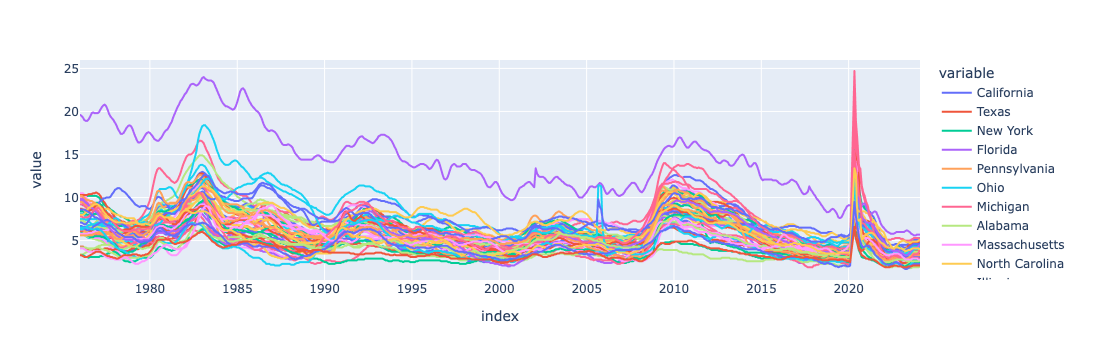

In [65]:
# Plot States Unemployment Rate
px.line(uemp_states)

In [79]:
uemp_states.min().min()

5.944123931623931

In [ ]:
uemp_states.max().max()

In [86]:
uemp_states.mean().sort_values(ascending = False)

Puerto Rico             14.193750
West Virginia            7.863715
Alaska                   7.639236
Michigan                 7.629340
District Of Columbia     7.463542
Mississippi              7.231771
California               7.161111
Louisiana                6.920486
Illinois                 6.776910
Oregon                   6.759896
Alabama                  6.735590
Washington               6.621701
New Mexico               6.612326
Nevada                   6.612326
Ohio                     6.513368
Kentucky                 6.467014
New York                 6.442014
Pennsylvania             6.293229
Rhode Island             6.289236
South Carolina           6.227951
New Jersey               6.204167
Arizona                  6.151215
Tennessee                6.143056
Arkansas                 6.117188
Texas                    5.914062
Florida                  5.905035
Indiana                  5.851562
Georgia                  5.830556
North Carolina           5.723785
Missouri      

In [ ]:
uemp_states.mean().mean()

In [89]:
# investigate Corona Peak
uemp_states.query('index >= 2020')

California  Texas  New York  Florida  Pennsylvania  Ohio  \
2020-01-01         4.3    3.5       4.1      3.0           4.5   4.4   
2020-02-01         4.4    3.6       4.1      3.0           4.7   4.6   
2020-05-01        15.8   11.6      16.7     14.2          12.9  12.8   
2020-06-01        13.8   10.1      13.6     11.8          11.3  10.9   
2020-07-01        13.2    9.3      12.5     11.8          10.4   9.8   
2020-08-01        11.9    8.1      10.8      8.8           9.3   8.3   
2020-09-01        10.0    7.7      10.2      8.1           8.8   7.6   
2020-10-01         9.3    7.1       9.2      7.1           8.1   6.8   
2020-11-01         9.0    7.0       9.0      6.6           7.9   6.4   
2020-12-01         9.0    6.9       8.7      6.4           7.6   6.3   
2021-01-01         8.7    6.7       8.6      5.9           7.4   6.0   
2021-02-01         8.6    6.6       8.4      5.6           7.1   5.9   
2021-03-01         8.4    6.4       8.1      5.4           6.8   5.8   
2021-04-01         8.3    6.2       7.9      5.2           6.6   5.7   
2021-05-01         7.9    6.0       7.5      4.9           6.3   5.5   
2021-06-01         7.8    5.8       7.5      4.9           6.1   5.3   
2021-07-01         7.4    5.6       7.0      4.6           5.9   5.1   
2021-08-01         7.0    5.3       6.8      4.4           5.6   4.9   
2021-09-01         6.5    5.1       6.3      4.1           5.2   4.7   
2021-10-01         6.1    4.9       5.9      3.9           4.9   4.5   
2021-11-01         5.7    4.6       5.6      3.8           4.7   4.3   
2021-12-01         5.5    4.5       5.5      3.6           4.5   4.2   
2022-01-01         5.2    4.3       5.2      3.5           4.3   4.1   
2022-02-01         4.8    4.1       4.8      3.3           4.2   4.0   
2022-03-01         4.4    3.9       4.6      3.2           4.2   3.9   
2022-04-01         4.2    3.8       4.4      3.1           4.1   3.9   
2022-05-01         4.1    3.8       4.3      3.0           4.1   3.9   
2022-06-01         4.0    3.8       4.2      2.9           4.1   3.9   
2022-07-01         3.9    3.8       4.0      2.8           4.0   4.0   
2022-08-01         3.8    3.8       3.9      2.8           4.0   4.1   
2022-09-01         4.0    3.9       4.0      2.8           4.0   4.1   
2022-10-01         4.2    4.0       4.1      2.9           3.9   4.1   
2022-11-01         4.3    4.0       4.2      2.8           3.9   4.0   
2022-12-01         4.4    4.1       4.2      2.8           3.8   3.9   
2023-01-01         4.5    4.1       4.1      2.8           3.8   3.8   
2023-02-01         4.5    4.0       4.0      2.8           3.7   3.7   
2023-03-01         4.5    4.0       4.0      2.8           3.5   3.5   
2023-04-01         4.5    4.0       3.9      2.7           3.4   3.4   
2023-05-01         4.5    4.0       3.9      2.8           3.3   3.3   
2023-06-01         4.6    3.9       4.0      2.8           3.2   3.3   
2023-07-01         4.7    3.9       4.1      2.9           3.2   3.4   
2023-08-01         4.8    3.9       4.3      3.0           3.3   3.5   
2023-09-01         5.0    3.9       4.4      3.0           3.3   3.6   
2023-10-01         5.1    3.9       4.6      3.1           3.4   3.6   
2023-11-01         5.1    3.9       4.6      3.1           3.4   3.6   
2023-12-01         5.1    3.9       4.6      3.1           3.4   3.6   
2024-01-01         5.2    3.9       4.5      3.1           3.4   3.7   
2024-02-01         5.3    3.9       4.4      3.1           3.4   3.7   

            Michigan  Alabama  Massachusetts  North Carolina  ...  Nebraska  \
2020-01-01       3.7      3.2            3.0             3.8  ...       3.0   
2020-02-01       3.7      3.3            3.0             3.8  ...       3.0   
2020-05-01      19.2     10.4           14.9            11.6  ...       6.4   
2020-06-01      14.5      8.6           14.5             9.7  ...       5.2   
2020-07-01      12.5      7.5           12.6             8.7  ...       4.6   
2020-08-0

## Pull February 2024 Unemployment Rate Per State

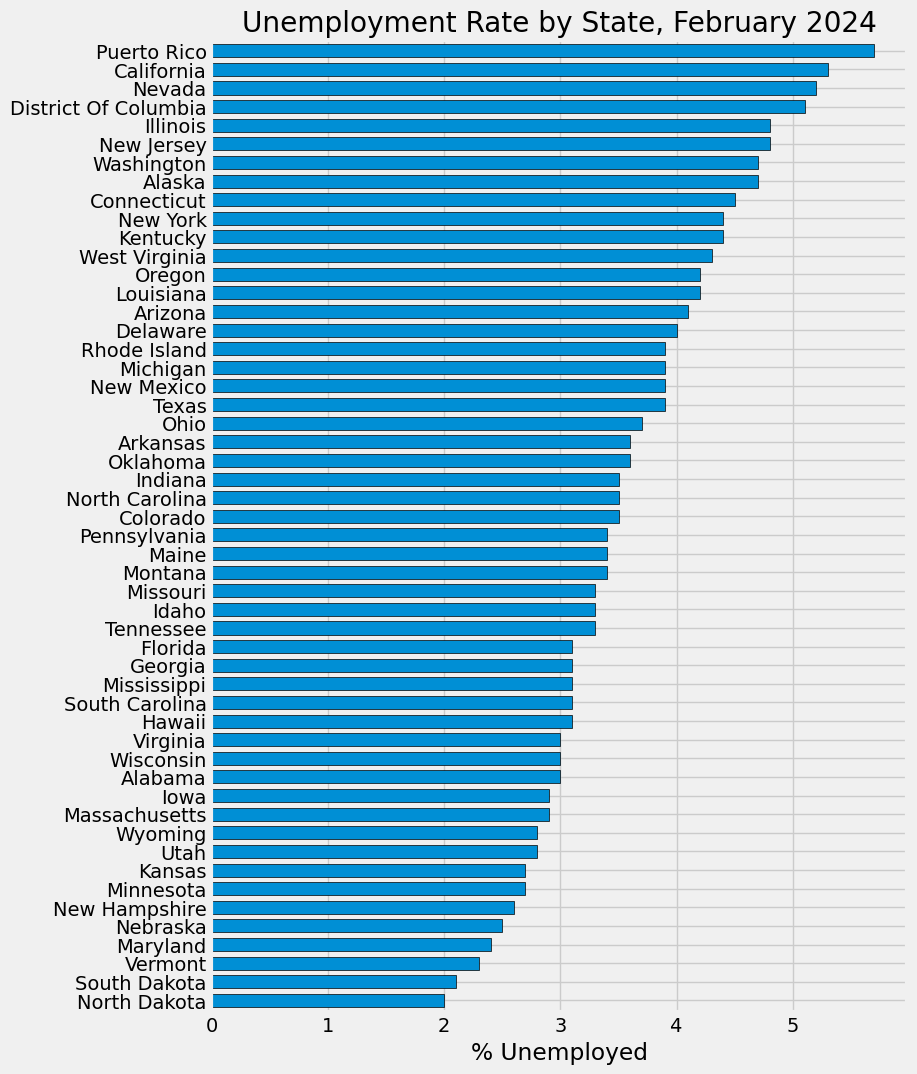

In [69]:
ax = uemp_states.loc[uemp_states.index == '2024-02-01'].T \
    .sort_values('2024-02-01') \
    .plot(kind='barh', figsize=(8, 12), width=0.7, edgecolor='black',
          title='Unemployment Rate by State, February 2024')
ax.legend().remove()
ax.set_xlabel('% Unemployed')
plt.savefig('uemp_rates_states_feb_2024.png', dpi=300)
plt.show()

In [103]:
uemp_states.loc["2024-02-01"].loc["Puerto Rico"]

5.7

In [104]:
uemp_states.loc["2024-02-01"].loc["North Dakota"]

2.0

In [105]:
uemp_states.loc["2024-02-01"].loc["South Dakota"]

2.1

## Pull Participation Rate

In [53]:
# pull monthly, seasonally adjusted participation rate for all states in percent
part_df = fred.search('participation rate state', filter=('frequency','Monthly'))
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')

In [55]:
part_id_to_state = part_df['title'].str.replace('Labor Force Participation Rate for ','').to_dict()

In [60]:
# get participation rates for all ids and concatonate them in one dataframe

all_results = []

for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    time.sleep(10) # Don't request to fast and get blocked
part_states = pd.concat(all_results, axis=1)

In [61]:
part_states.columns = [part_id_to_state[c] for c in part_states.columns]

# Plot Unemployment vs Participation for each State

In [62]:
# Fix DC
uemp_states = uemp_states.rename(columns={'the District of Columbia':'District Of Columbia'})

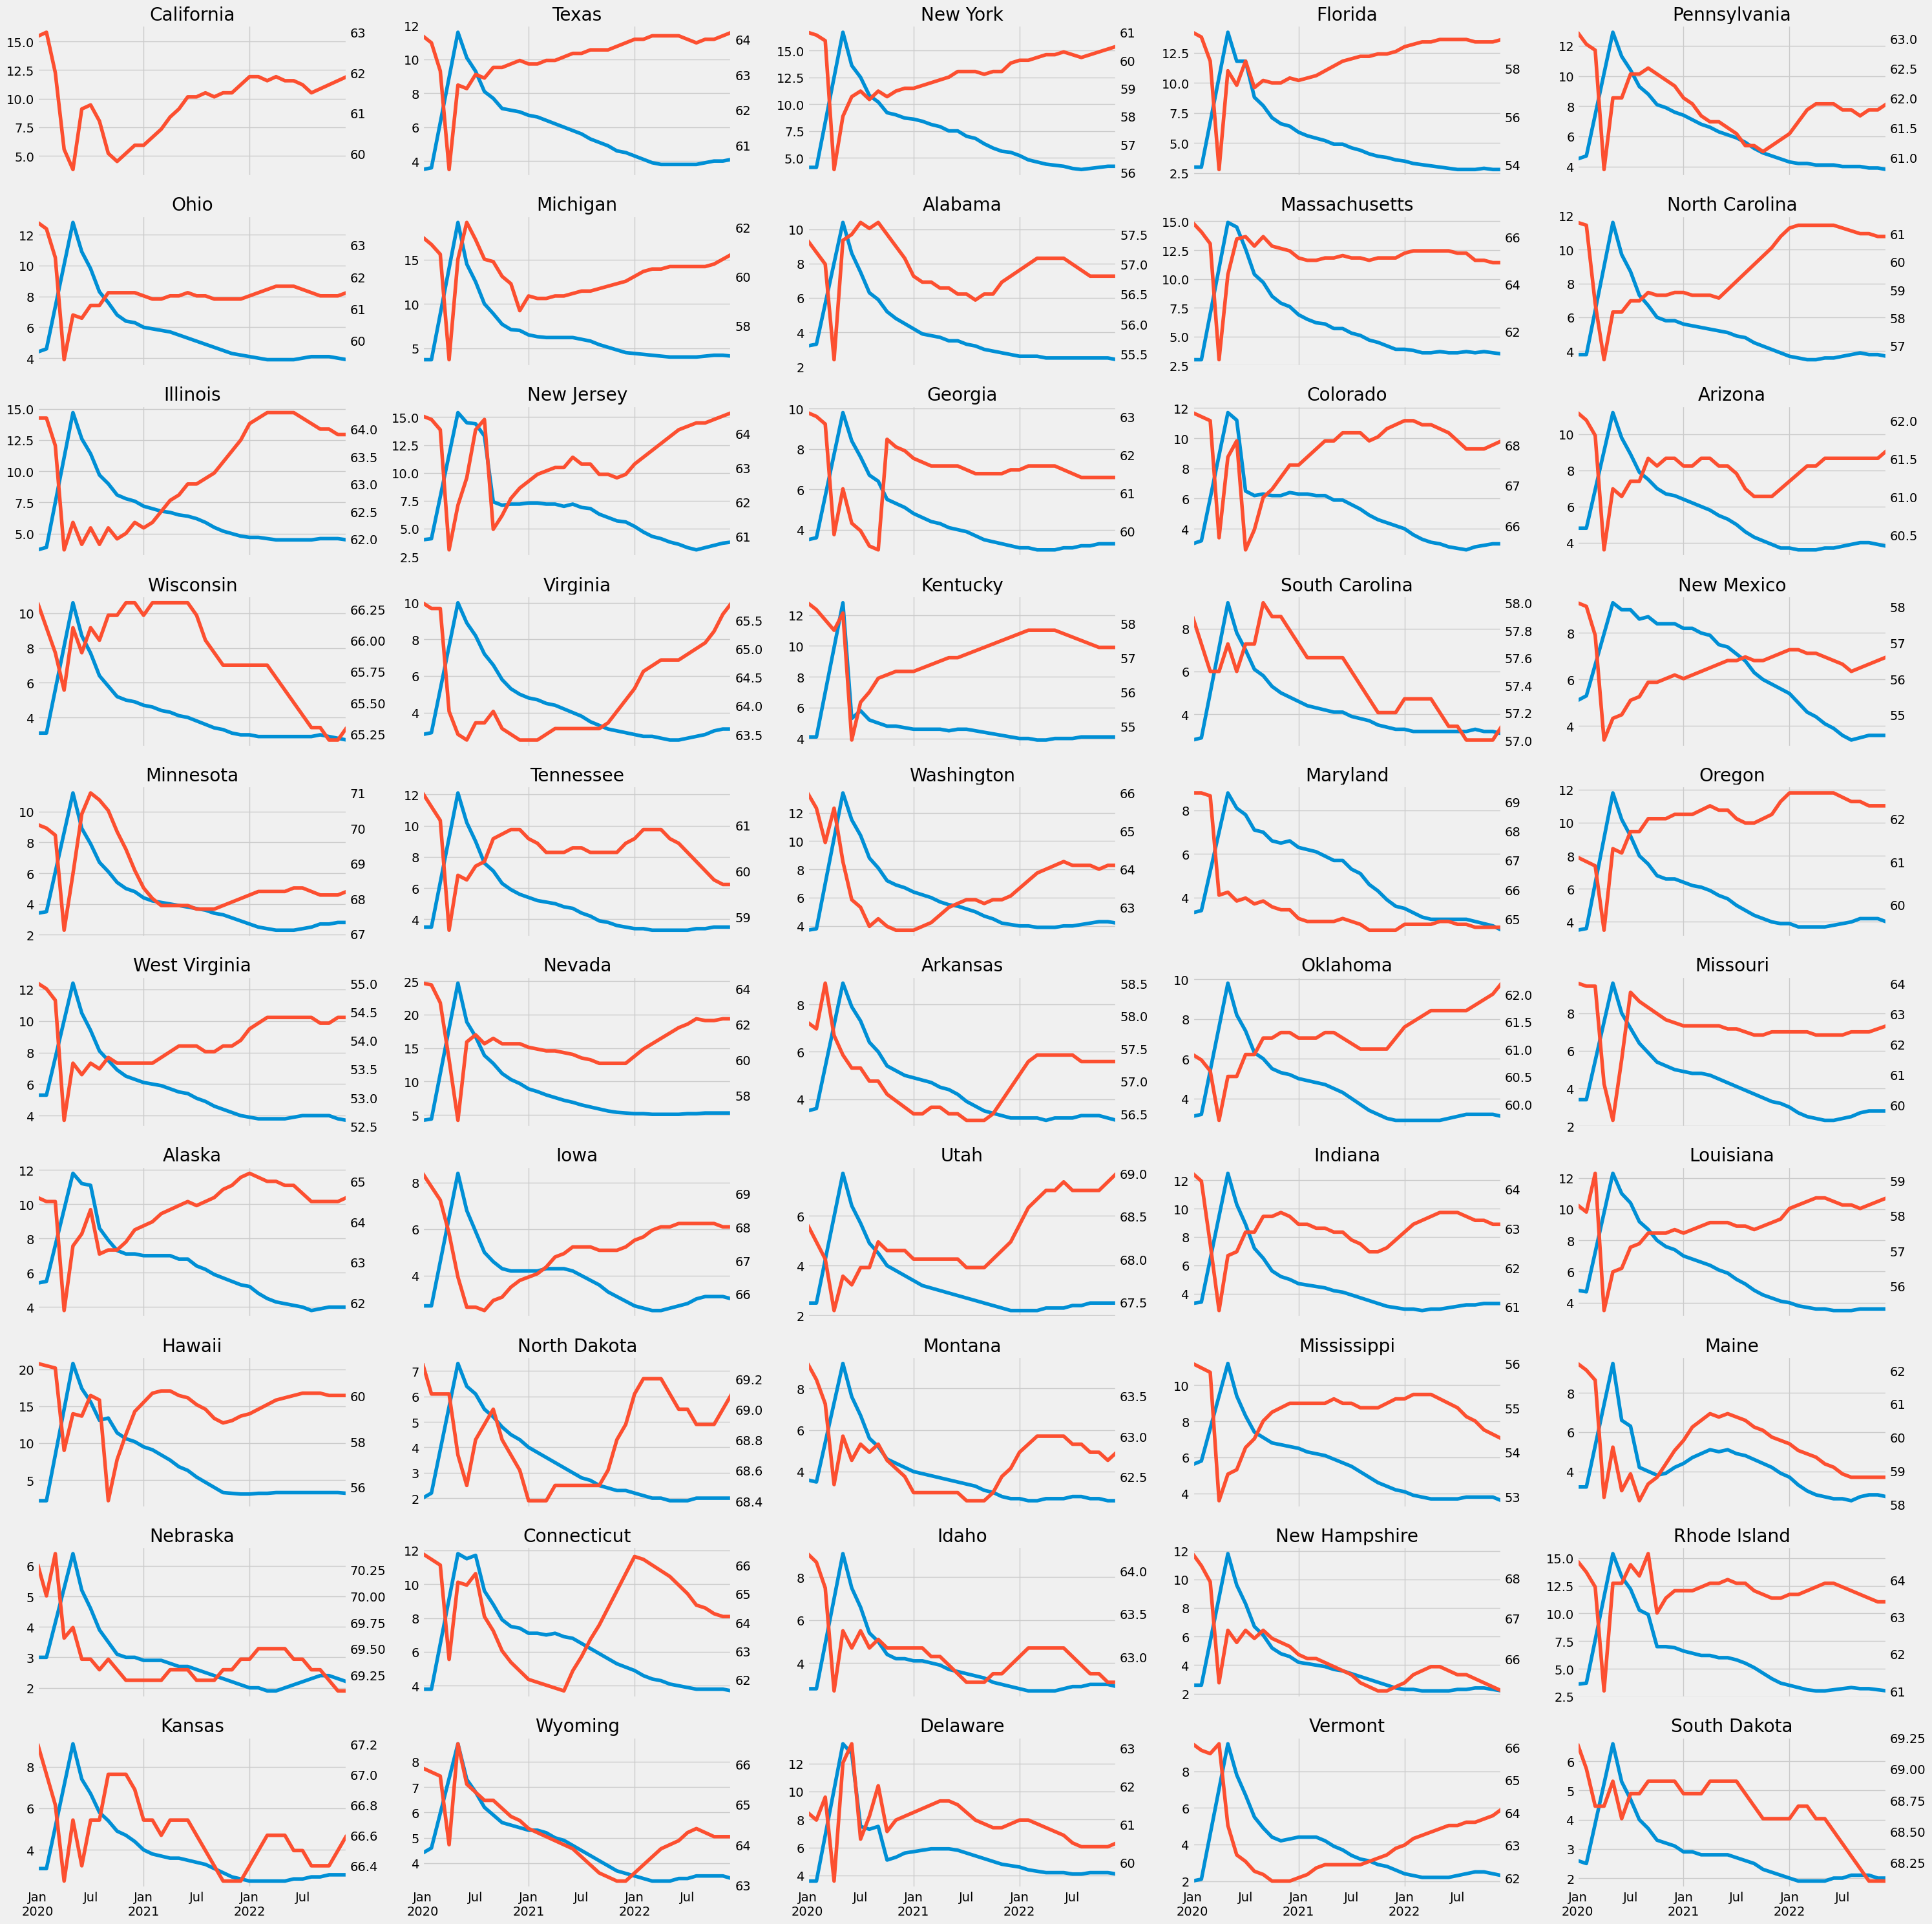

In [70]:
fig, axs = plt.subplots(10, 5, figsize=(30, 30), sharex=True)
axs = axs.flatten()

i = 0
for state in uemp_states.columns:
    if state in ["District Of Columbia","Puerto Rico"]:
        continue
    ax2 = axs[i].twinx()
    uemp_states.query('index >= 2020 and index < 2023')[state] \
        .plot(ax=axs[i], label='Unemployment')
    part_states.query('index >= 2020 and index < 2023')[state] \
        .plot(ax=ax2, label='Participation', color=color_pal[1])
    ax2.grid(False)
    axs[i].set_title(state)
    i += 1
plt.tight_layout()
plt.savefig('unemp_vs_part.png', dpi=300)
plt.show()

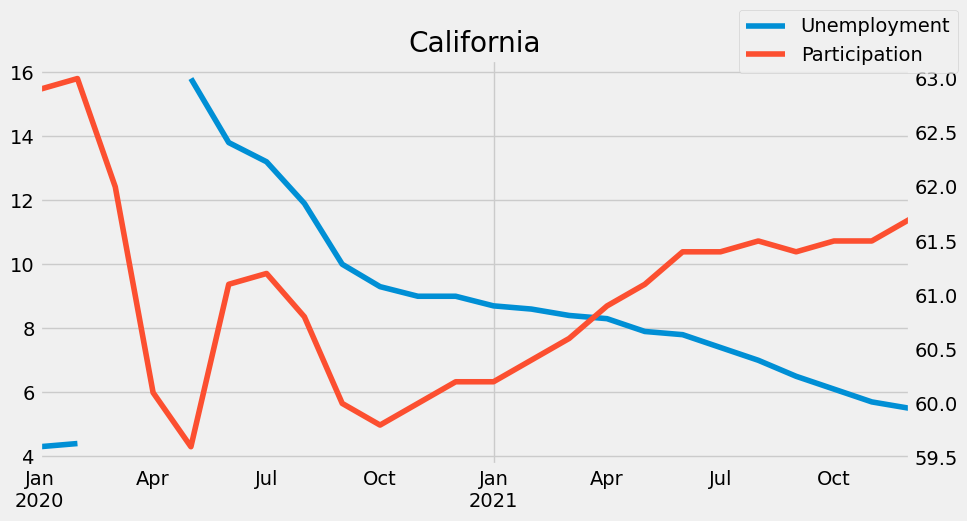

In [71]:
state = 'California'
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
ax2 = ax.twinx()
uemp_states2 = uemp_states.asfreq('MS')
l1 = uemp_states2.query('index >= 2020 and index < 2022')[state] \
    .plot(ax=ax, label='Unemployment')
l2 = part_states.dropna().query('index >= 2020 and index < 2022')[state] \
    .plot(ax=ax2, label='Participation', color=color_pal[1])
ax2.grid(False)
ax.set_title(state)
fig.legend(labels=['Unemployment','Participation'])
plt.savefig('unemp_vs_part_california.png', dpi=300)
plt.show()